# 2D Isostatic gravity inversion - Inverse Problem

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
#matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math
import cPickle as pickle
import datetime
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Observation coordinates.

In [3]:
# Model`s limits
ymin = 0.0
ymax = 383000.0
zmin = -1000.0
zmax = 45000.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2350.0])
ds1 = np.array([2855.0])
dcc = np.array([2870.0])
doc = np.array([2885.0])
dm = np.array([3240.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 350000.0
# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc    
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))

# S0 => isostatic compensation surface (Airy's model)
S0 = np.array([41000.0])

## Synthetic data

In [8]:
gsyn = np.reshape(np.loadtxt('../data/volcanic-margin-synthetic-gravity-data.txt'),(n,1))

## Water bottom

In [9]:
bathymetry = np.reshape(np.loadtxt('../data/etopo1-pelotas.txt'),(n,1))
tw = 0.0 - bathymetry

## True surfaces

In [10]:
toi = np.reshape(np.loadtxt('../data/volcanic-margin-true-toi-surface.txt'),(n,1))

true_basement = np.reshape(np.loadtxt('../data/volcanic-margin-true-basement-surface.txt'),(n,1))

true_moho = np.reshape(np.loadtxt('../data/volcanic-margin-true-moho-surface.txt'),(n,1))

# True reference moho surface (SR = S0+dS0)
true_dS0 = np.array([2200.0])

In [11]:
# layer sediments thickness
ts0 = toi - tw
# True layer sediments thickness
true_ts1 = true_basement - toi
# True thickness sediments vector
true_ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(true_ts1,(1,n))))
# True layer mantle thickness
true_tm = S0 - true_moho
# true parameters vector
ptrue = np.vstack((true_ts1, true_tm, true_dS0))

## Initial guess surfaces

In [12]:
# initial guess basement surface
ini_basement = np.reshape(np.loadtxt('../data/volcanic-margin-initial-basement-surface.txt'),(n,1))

# initial guess moho surface
ini_moho = np.reshape(np.loadtxt('../data/volcanic-margin-initial-moho-surface.txt'),(n,1))

# initial guess reference moho surface (SR = S0+dS0)
ini_dS0 = np.array([8500.0])
ini_RM = S0 + ini_dS0

In [13]:
# initial guess layer igneous thickness
ini_ts1 = ini_basement - toi
# initial guess anti-root layer thickness
ini_tm = S0 - ini_moho
# initial guess parameters vector
p0 = np.vstack((ini_ts1, ini_tm, ini_dS0))

## Known depths

In [14]:
# Known values: basement and moho surfaces

#base_known = np.loadtxt('../data/volcanic-margin-basement-known-depths.txt')
base_known = np.loadtxt('../data/volcanic-margin-basement-more-known-depths.txt')
base_known_new = np.loadtxt('../data/volcanic-margin-basement-new-known-depths.txt')
base_known_old = np.loadtxt('../data/volcanic-margin-basement-known-depths.txt')

moho_known = np.loadtxt('../data/volcanic-margin-moho-known-depths.txt')

In [15]:
(rs,index_rs) = fc.base_known_function(dy,tw,yc,base_known,ts0,two_layers=True)

In [16]:
(rm,index_rm) = fc.moho_known_function(dy,yc,S0,moho_known)

In [17]:
index_base = index_rs
index_moho = index_rm - n

assert_almost_equal(base_known[:,0], yc[index_base][:,0], decimal=6)

assert_almost_equal(moho_known[:,0], yc[index_moho][:,0], decimal=6)

assert_almost_equal(true_ts1[index_base][:,0], rs[:,0], decimal=6)

assert_almost_equal((true_tm[index_moho][:,0]), rm[:,0], decimal=6)

## Initial guess data

In [18]:
g0 = np.reshape(np.loadtxt('../data/volcanic-margin-initial-guess-gravity-data.txt'),(n,1))

### parameters vector box limits

In [19]:
# true thickness vector limits
print 'ts =>', np.min(ptrue[0:n]),'-', np.max(ptrue[0:n])
print 'tm =>', np.min(ptrue[n:n+n]),'-', np.max(ptrue[n:n+n])
print 'dS0 =>', ptrue[n+n]

ts => 0.0 - 21690.6561553
tm => 3041.89136074 - 23955.3832955
dS0 => [ 2200.]


In [20]:
# initial guess thickness vector limits
print 'ts =>', np.min(p0[0:n]),'-', np.max(p0[0:n])
print 'tm =>', np.min(p0[n:n+n]),'-', np.max(p0[n:n+n])
print 'dS0 =>', p0[n+n]

ts => 6709.95000179 - 12194.8641075
tm => 1067.94758938 - 12135.7252242
dS0 => [ 8500.]


In [21]:
# defining parameters values limits
pjmin = np.zeros((len(ptrue),1))
pjmax = np.zeros((len(ptrue),1))
pjmin[0:n] = 0.0
pjmax[0:n] = 25000.
pjmin[n:n+n] = 0.0
pjmax[n:n+n] = 28000.
pjmin[n+n] = 0.0
pjmax[n+n] = 12000.

### Inversion code

In [22]:
#Parametros internos para implementacao da funcao (convergencia, numero de iteracoes, etc.)
beta = 10**(-3)
itmax = 50
itmax_marq = 10
lamb = 1.
mi = 10**(-3)
dmi = 10.
dp1 = 1.
dp2 = 1.

In [23]:
#inicializacao de variaveis
ymin = area[0]
ymax = area[1]
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0
n = len(yc) # numero de dados observados
m = 2*n+1 # numero de parametros a inverter
    
# calculo da contribuicao dos prismas que formam a camada de agua.
prism_w = fc.prism_w_function(xmax,xmin,dy,edge,dw,dcc,tw,yc)
gzw = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_w)
   

In [24]:
# matrizes
I = np.identity(m)
W0 = np.identity(n-1)
R0 = fc.R_matrix_function(n,isostatic=True)
R = fc.R_matrix_function(n)
C = fc.C_matrix_function(ds,dm,dc,two_layers=True)
D = fc.D_matrix_function(dw,dc,ds,two_layers=True)
A = fc.A_matrix_function(n,rs,index_rs)
B = fc.B_matrix_function(n,rm,index_rm)
G0 = fc.G_matrix_function(xmax,xmin,dy,edge,dp1,dp2,S0,dw,ds,dm,dcc,dc,tw,p0,yc,ts0,two_layers=True)

# Hessianas
Hess_phi = (2/n)*G0.T.dot(G0)
Hess_psi0 = 2*C.T.dot(R0.T.dot(W0.T.dot(W0.dot(R0.dot(C)))))
Hess_psi1 = 2*R.T.dot(R)
Hess_psi2 = 2*A.T.dot(A)
Hess_psi3 = 2*B.T.dot(B)

In [25]:
# Normalizacao dos vinculos
diag_phi = np.diag(Hess_phi)
diag_psi0 = np.diag(Hess_psi0)
diag_psi1 = np.diag(Hess_psi1)
diag_psi2 = np.diag(Hess_psi2)
diag_psi3 = np.diag(Hess_psi3)

f_phi = np.median(diag_phi)
f_psi0 = np.median(diag_psi0)
f_psi1 = np.median(diag_psi1)
#f_psi2 = np.median(diag_psi2)
#f_psi3 = np.median(diag_psi3)
f_psi2 = 2.
f_psi3 = 2.
print f_phi, f_psi0, f_psi1, f_psi2, f_psi3

1.60085970901e-08 3600.0 4.0 2.0 2.0


In [26]:
# coeficientes dos vinculos
alpha0 = 0*(f_phi/f_psi0)*10**(2) # vinculo isostatico
alpha1 = (f_phi/f_psi1)*10**(1) # vinculo suavidade
alpha2 = (f_phi/f_psi2)*10**(1) # vinculo de igualdade espessura sedimento
alpha3 = (f_phi/f_psi3)*10**(2) # vinculo de igualdade espessura (S0 - tm)
print alpha0, alpha1, alpha2, alpha3

0.0 4.00214927252e-08 8.00429854503e-08 8.00429854503e-07


In [27]:
p1 = p0.copy()
g1 = g0.copy()

gama1 = fc.gama_function(alpha0,alpha1,alpha2,alpha3,lamb,S0,tw,gsyn,g1,p1,rs,rm,W0,R0,C,D,R,A,B,ts0,two_layers=True)
gama_list = [gama1]

k0=0
k1=0
k2=0
k3=0

#implementacao da funcao
for it in range (itmax):

    p1_hat = - np.log((pjmax - p1)/(p1-pjmin))
    G1 = fc.G_matrix_function(xmax,xmin,dy,edge,dp1,dp2,S0,dw,ds,dm,dcc,dc,tw,p1,yc,ts0,two_layers=True)
    
    grad_phi = (-2/n)*G1.T.dot(gsyn - g1)
    Hess_phi = (2/n)*G1.T.dot(G1)
        
    grad_psi0 = fc.grad_ps0_function(S0,tw,p1,W0,R0,C,D,ts0,two_layers=True)
    grad_psi1 = fc.grad_psi1_function(p1,R)
    grad_psi2 = fc.grad_psi2_function(p1,rs,A)
    grad_psi3 = fc.grad_psi2_function(p1,rm,B)
    
    grad_gama = grad_phi + lamb*(alpha0*grad_psi0+alpha1*grad_psi1+alpha2*grad_psi2+alpha3*grad_psi3)
    Hess_gama = Hess_phi+lamb*(alpha0*Hess_psi0+alpha1*Hess_psi1+alpha2*Hess_psi2+alpha3*Hess_psi3)
    
    T = fc.T_matrix_function(pjmin, pjmax, p1)
        
    for it_marq in range(itmax_marq):
            
        deltap = np.linalg.solve((Hess_gama.dot(T) + mi*I), -grad_gama)
        p2_hat = p1_hat + deltap
        p2 = pjmin + ((pjmax - pjmin)/(1 + np.exp(-p2_hat)))

        #Calculo do vetor de dados preditos e da funcao phi
        prism_s = fc.prism_s_function(xmax,xmin,dy,edge,ds,dcc,tw,p2,yc,ts0,two_layers=True)
        prism_c = fc.prism_c_function(xmax,xmin,dy,edge,S0,dcc,dc,tw,p2,yc,ts0,two_layers=True)
        prism_m = fc.prism_m_function(xmax,xmin,dy,edge,S0,dcc,dm,p2,yc)
        
        g2 = np.reshape(fc.g_function(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),gzw,prism_s,prism_c,prism_m),(n,1))
        gama2 = fc.gama_function(alpha0,alpha1,alpha2,alpha3,lamb,S0,tw,gsyn,g2,p2,rs,rm,W0,R0,C,D,R,A,B,ts0,two_layers=True)
        
        #Verificando se a funcao phi esta diminuindo
        dgama = gama2 - gama1
        if dgama > 0.:
            mi *= dmi
            print 'k0=',k0
            k0 += 1
            
        else:
            mi /= dmi
            #print 'k1=',k1
            #k1 += 1
            break
    
    p1 = p2.copy()
    g1 = g2.copy()
    
    #Testando convergencia da funcao phi
    if (dgama < 0.) & (abs(gama1 - gama2) < beta):
    #if fc.convergence_function(gama1, gama2, beta):
        #print 'k2=',k2
        #k2 += 1
        print 'convergence achieved'
        break
        
    #Atualizando variaveis
    else:
        print 'k3=',k3
        k3 += 1       
        gama1 = gama2.copy()
        print gama1
        gama_list.append(gama1)

    thicknesses = tw + ts0 + p2[0:n] + p2[n:n+n]
    assert np.alltrue(thicknesses <= S0), 'sum of the thicknesses shall be less than or equal to isostatic compensation surface'
    
    p = p2.copy()
    g = g2.copy()

k3= 0
181.796514635
k3= 1
79.0099034239
k3= 2
65.0416477806
k0= 0
k3= 3
4.12454905052
k0= 1
k3= 4
2.85708590885
k0= 2
k3= 5
2.53956784802
k0= 3
k0= 4
k3= 6
2.49619880244
k0= 5
k3= 7
2.47959803574
k0= 6
k0= 7
k3= 8
2.472532683
k0= 8
k3= 9
2.46688076737
k0= 9
k3= 10
2.46037086155
k0= 10
k3= 11
2.45294790185
k0= 11
k3= 12
2.44469230299
k0= 12
k3= 13
2.43575465389
k0= 13
k3= 14
2.4263233979
k0= 14
k3= 15
2.41659277432
k0= 15
k3= 16
2.4067369326
k3= 17
2.39465553135
k0= 16
k3= 18
2.25584697758
k0= 17
k3= 19
2.20122760963
k0= 18
k3= 20
2.15384678258
k0= 19
k3= 21
2.11399188139
k0= 20
k3= 22
2.07963351999
k0= 21
k3= 23
2.04971872691
k0= 22
k3= 24
2.02348265605
k0= 23
k3= 25
2.00034942535
k0= 24
k3= 26
1.97986933227
k0= 25
k3= 27
1.9616829863
k0= 26
k3= 28
1.94549786614
k0= 27
k3= 29
1.93107189535
k0= 28
k3= 30
1.91820151787
k0= 29
k3= 31
1.90671294085
k0= 30
k3= 32
1.89645571152
k0= 31
k3= 33
1.88729803244
k0= 32
k3= 34
1.87912335636
k3= 35
1.87588726143
k0= 33
k3= 36
1.8302062193
k0= 34
k3= 

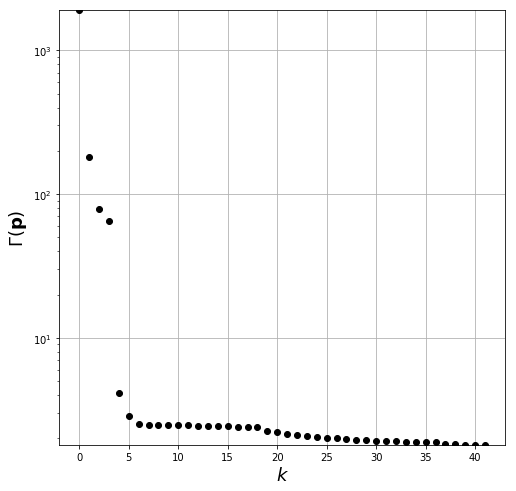

In [34]:
it = [i for i in range(len(gama_list))]
#plt.figure(figsize=(8,8))
ax = plt.figure(figsize=(8,8)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(gama_list,'ko')
plt.yscale('log')
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$\Gamma(\mathbf{p})$', fontsize=18)
plt.grid()
#plt.xlim(-1,50)
#plt.xlim(-1, len(gama_list)+5)
plt.ylim(np.min(gama_list)-3*np.min(gama_list),np.max(gama_list)+3*np.min(gama_list))
#mpl.savefig('../data/fig/volcanic-margin-gama-list-alphas-X_1_1_2_more-known-depths.png', dpi='figure', bbox_inches='tight')
plt.show()

## Lithostatic Stress

In [29]:
sgm_true = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*true_ts1 + dc*(S0-tw-ts0-true_ts1-true_tm)+dm*true_tm)

sgm = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*p[0:n] + dc*(S0-tw-ts0-p[0:n]-p[n:n+n])+dm*p[n:n+n])

## Inversion model plot

In [30]:
# Inverrsion results
RM = S0 + p[n+n]
basement = tw + ts0 + p[0:n]
moho = S0 - p[n:n+n]

print ptrue[n+n], p[n+n]

[ 2200.] [ 1807.2569842]


In [31]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments0 = []
for (yi, twi, s0i) in zip(yc, np.reshape(tw,(n,)), np.reshape(toi,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments0.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, s0i, s0i]]).T,
                                                    props={'density': ds0 - dcc}))
    
polygons_sediments1 = []
for (yi, s0i, s1i) in zip(yc, np.reshape(toi,(n,)), np.reshape(basement,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments1.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [s0i, s0i, s1i, s1i]]).T,
                                                   props={'density': ds1 - dcc}))
    
polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, S0+p[n+n], S0+p[n+n]]]).T,
                                                    props={'density': dm - dcc}))

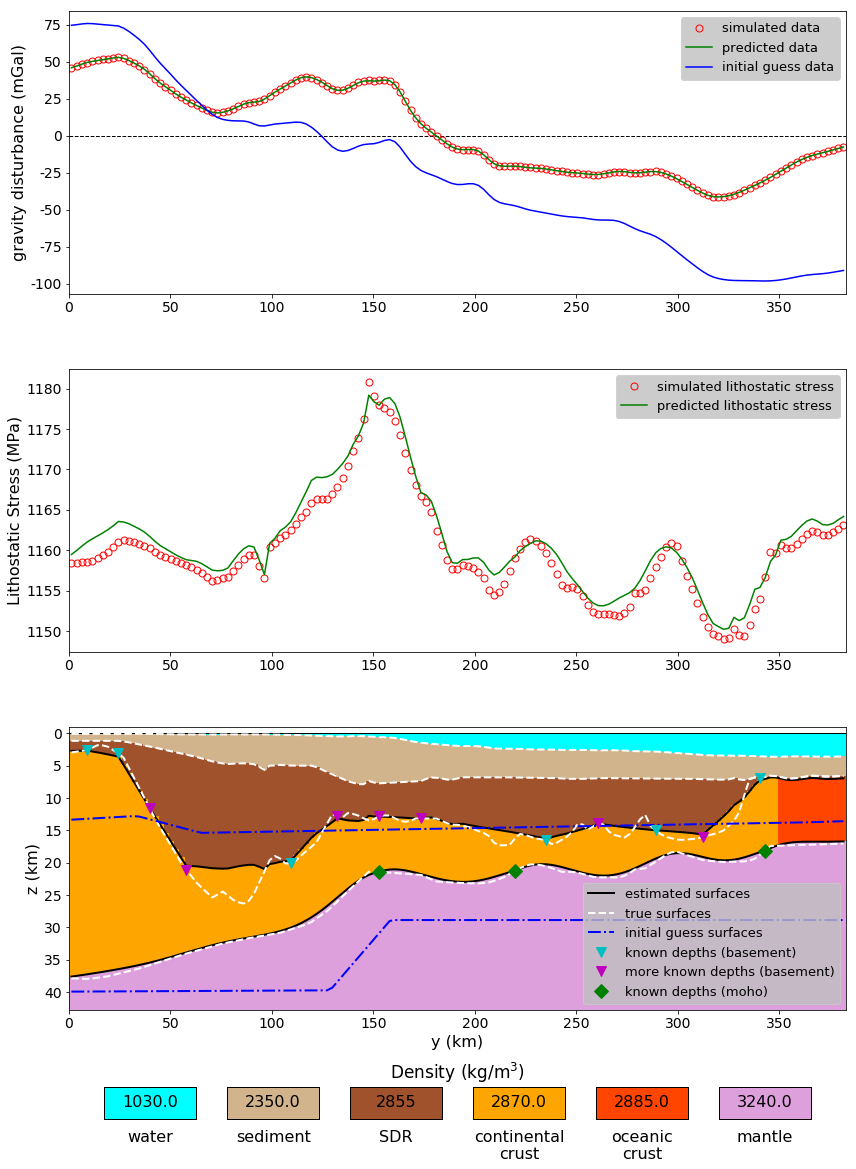

In [33]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,16))

import matplotlib.gridspec as gridspec
heights = [8, 8, 8, 1]
gs = gridspec.GridSpec(4, 1, height_ratios=heights)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='--', linewidth=1)
ax1.plot(0.001*yc, gsyn, 'or', mfc='none', markersize=7, label='simulated data')
ax1.plot(0.001*yc, g, '-g', label='predicted data')
ax1.plot(0.001*yc, g0, '-b', label='initial guess data')
ax1.set_xlim(0.001*ymin, 0.001*ymax)
ax1.set_ylabel('gravity disturbance (mGal)', fontsize=16)
ax1.set_xticklabels(['%g'% (l) for l in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='best', fontsize=13, facecolor='silver')

ax2.plot(0.001*yc, sgm_true, 'or', mfc='none', markersize=7, label='simulated lithostatic stress')
ax2.plot(0.001*yc, sgm, '-g', label='predicted lithostatic stress')
ax2.set_xlim(0.001*ymin, 0.001*ymax)
#ax2.set_ylim(752.,812.)
ax2.set_ylabel('Lithostatic Stress (MPa)', fontsize=16)
ax2.set_xticklabels(['%g'% (l) for l in ax2.get_xticks()], fontsize=14)
ax2.set_yticklabels(['%g'% (l) for l in ax2.get_yticks()], fontsize=14)
ax2.legend(loc='best', fontsize=13, facecolor='silver')

ax3.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    tmpx = [x for x in pwi.x]
    tmpx.append(pwi.x[0])
    tmpy = [y for y in pwi.y]
    tmpy.append(pwi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='aqua')
for (ps0i) in (polygons_sediments0):
    tmpx = [x for x in ps0i.x]
    tmpx.append(ps0i.x[0])
    tmpy = [y for y in ps0i.y]
    tmpy.append(ps0i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='tan')
for (ps1i) in (polygons_sediments1):
    tmpx = [x for x in ps1i.x]
    tmpx.append(ps1i.x[0])
    tmpy = [y for y in ps1i.y]
    tmpy.append(ps1i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='sienna')
for (pci) in (polygons_crust[:len(yc[aux])]):
    tmpx = [x for x in pci.x]
    tmpx.append(pci.x[0])
    tmpy = [y for y in pci.y]
    tmpy.append(pci.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    tmpx = [x for x in pcoi.x]
    tmpx.append(pcoi.x[0])
    tmpy = [y for y in pcoi.y]
    tmpy.append(pcoi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='orangered')
for (pmi) in (polygons_mantle):
    tmpx = [x for x in pmi.x]
    tmpx.append(pmi.x[0])
    tmpy = [y for y in pmi.y]
    tmpy.append(pmi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='plum')

ax3.plot(yc, tw, '--w', linewidth=2)
ax3.plot(yc, toi, '--w', linewidth=2)
ax3.plot(yc, basement, '-k', linewidth=2, label='estimated surfaces')
ax3.plot(yc, moho, '-k', linewidth=2)
ax3.plot(yc, true_basement, '--w', linewidth=2, label='true surfaces')
ax3.plot(yc, true_moho, '--w', linewidth=2)
ax3.plot(yc, ini_basement, '-.b', linewidth=2, label='initial guess surfaces')
ax3.plot(yc, ini_moho, '-.b', linewidth=2)
#ax3.plot(base_known[:,0], base_known[:,1], 'vc', markersize=9.5, label='known depths (basement)')
ax3.plot(base_known_old[:,0], base_known_old[:,1], 'vc', markersize=9.5, label='known depths (basement)')
ax3.plot(base_known_new[:,0], base_known_new[:,1], 'vm', markersize=9.5, label='more known depths (basement)')
ax3.plot(moho_known[:,0], moho_known[:,1], 'Dg', markersize=9.5, label='known depths (moho)')
ax3.set_ylim((S0+p[n+n]), zmin)
ax3.set_xlim(ymin, ymax)
ax3.set_xlabel('y (km)', fontsize=16)
ax3.set_ylabel('z (km)', fontsize=16)
ax3.set_xticklabels(['%g'% (0.001*l) for l in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(['%g'% (0.001*l) for l in ax3.get_yticks()], fontsize=14)
ax3.legend(loc='lower right', fontsize=13, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density (kg/m$^{3}$)', fontsize=17)
ax4.axis('off')

layers_list1 = ['water', 'sediment', 'SDR', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', '', 'crust', 'crust', '']
colors_list = ['aqua', 'tan', 'sienna', 'orange', 'orangered', 'plum']
density_list = ['1030.0', '2350.0', '2855', '2870.0', '2885.0', '3240.0']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    yi_text3 = Y - Y*0.075
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax4.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax4.fill(tmpx, tmpy, color=color)
    ax4.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.13), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.13), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text3, density, fontsize=(w*0.13), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()    
    
#mpl.savefig('../data/fig/volcanic-margin-grafics-estimated-model-alphas_X_1_1_2_more-known-depths.png', dpi='figure', bbox_inches='tight')
plt.show()      